In [1]:
# jupyter extension that allows reloading functions from imports without clearing kernel :D
%load_ext autoreload
%autoreload 2

In [2]:
import focusstack
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
from utils import video2imageFolder, resize_im, get_reference_distances_from_original_files

# Image collection and preparation

Convert macro video into individual frames. Optionally, remove frames from set where whole object is blurry before continuing.

In [16]:
input_video = "images/strawberry_video/MVI_0592.MOV"
output_dir = "images/strawberry_video/images3"

if len(os.listdir(output_dir)) != 0:
    print("Output directory is not empty, skipping video processing.")
else:
    print("Processing video into frames")
    video2imageFolder(input_video, output_dir)

Output directory is not empty, skipping video processing.


Plotting the first photo in the example set. The millimeter ruler to the right is used as a reference for depth, and is used to annotate the image file names.

(1080, 1920, 3)


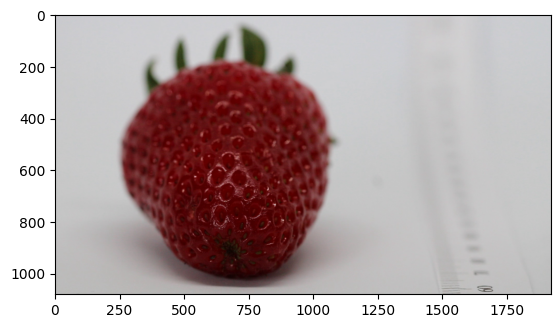

In [4]:
dir = "images/strawberry_video/images3"
img = "f0091.jpg"
im = cv2.imread(f"{dir}/{img}")
print(im.shape)
plt.figure()
plt.imshow(im[:,:,[2,1,0]])

The images can be cropped to a square shape to remove the reference ruler and excess white space

(1080, 1080, 3)


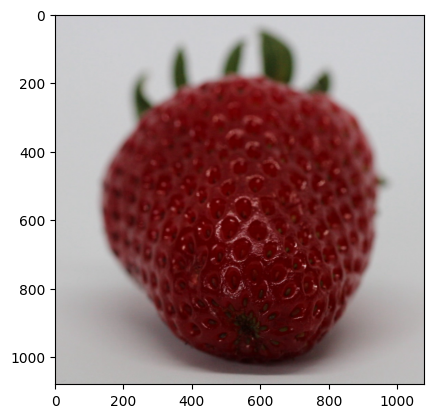

In [5]:
im_crop = im[:1080,120:1200,:]
print(im_crop.shape)
plt.figure()
plt.imshow(im_crop[:,:,[2,1,0]])

# Focus Stacking

In [6]:
def runner(dir, crop=None, resize=None):
    focusimages = []
    image_files = sorted(os.listdir(dir))
    for img in image_files:
        if img.split(".")[-1].lower() not in ["jpg", "jpeg", "png"]:
            image_files.remove(img)
        im = cv2.imread(f"{dir}/{img}")
        if crop:
            im = im[crop[0]:crop[1],crop[2]:crop[3],:]
        if resize:
            im = resize_im(im, resize)
        focusimages.append(im)

    merged, mask = focusstack.focus_stack(focusimages)
    return merged, mask

In [7]:
resize = 50
crop = [0,1080,120,1200]
dir = "images/strawberry_video/images3"
merged, mask = runner(dir, crop=crop, resize=resize)

Detecting features of base image
Aligning images
Computing the laplacian of the blurred images
Shape of array of laplacians = (128, 540, 540)


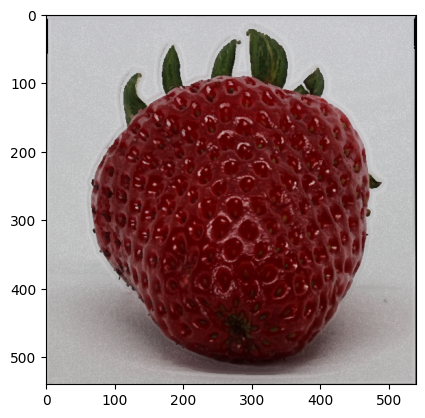

In [8]:
plt.figure()
plt.imshow(merged[:,:,[2,1,0]])

In [9]:
cv2.imwrite("strawberry_merged_2.png", merged)

True

# Depth Map Generation

In [10]:
# furthest image is baseline and should have a depth of 0
# other images estimated from base image
estimated_distances = get_reference_distances_from_original_files(dir)
print(estimated_distances)

[255 252 250 248 246 244 242 240 238 236 234 232 230 228 226 224 222 220
 218 216 214 212 210 208 206 204 202 200 198 196 194 192 190 188 186 184
 182 180 178 176 174 172 170 168 166 164 162 160 158 156 154 152 150 148
 146 144 142 140 138 136 134 132 130 128 126 124 122 120 118 116 114 112
 110 108 106 104 102 100  98  96  94  92  90  88  86  84  82  80  78  76
  74  72  70  68  66  64  62  60  58  56  54  52  50  48  46  44  42  40
  38  36  34  32  30  28  26  24  22  20  18  16  14  12  10   8   6   4
   2   0]


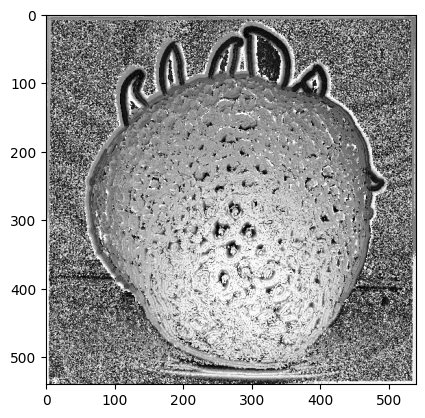

In [11]:
(H, W, _) = merged.shape
depth_map = np.zeros((H, W), dtype=np.uint8)
for i in range(mask.shape[0]):
    depth_map[mask[i]==True] = estimated_distances[i]

plt.figure()
plt.imshow(depth_map, cmap="gray")

A mask is created manually outside of this notebook in Windows paint. This mask is then uploaded to be applied to the depth map to remove the background

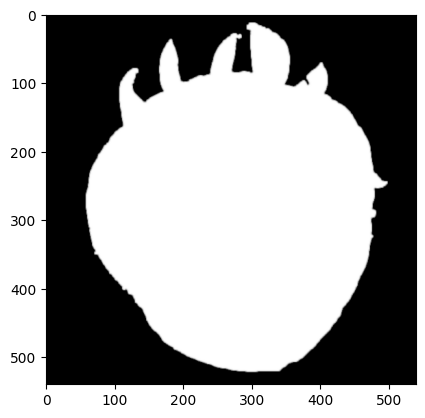

In [12]:
mask_file = "strawberry_merged_mask.png"
mask = cv2.imread(mask_file)
plt.figure()
plt.imshow(mask, cmap="gray")

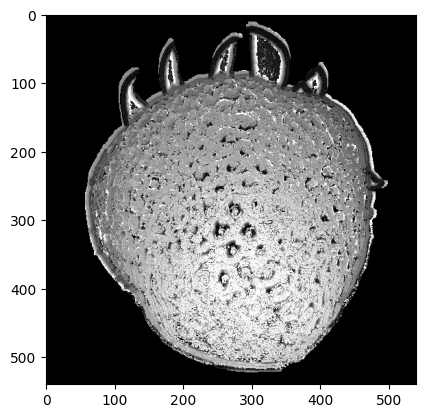

In [13]:
gray_mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
masked_depth_map = cv2.bitwise_and(depth_map, depth_map, mask=gray_mask)
plt.figure()
plt.imshow(masked_depth_map, cmap="gray")

In [14]:
cv2.imwrite("strawberry_masked_depth_map.png", masked_depth_map)

True

# Generate 3D Model Using Depth Map In OpenGL

# Generate Point Cloud and 3D Model Using Alternate Methods